In [ ]:
import os
import sys
import subprocess
import pkg_resources


def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])


# List of required packages
required_packages = ['ipywidgets', 'jupyter', 'matplotlib', 'numpy',
                     'optuna-integration[sklearn]', 'optuna',  'pandas', 'scikit-learn']

# Check if packages are installed, and install if not
for package in required_packages:
    try:
        pkg_resources.get_distribution(package)
    except pkg_resources.DistributionNotFound:
        install(package)

# Check if the environment is activated
if 'CONDA_DEFAULT_ENV' in os.environ:
    print(f"Environment '{os.environ['CONDA_DEFAULT_ENV']}' is activated.")
else:
    print("No specific environment is activated.")

Environment 'research' is activated.


In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from warnings import simplefilter

if not sys.warnoptions:
    simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"
np.random.seed(42)

In [ ]:
# Load the Boston dataset
data_url = 'http://lib.stat.cmu.edu/datasets/boston'
raw_df = pd.read_csv(data_url, sep='\s+', skiprows=22,  # type: ignore
                     header=None)  # type: ignore
X = pd.DataFrame(np.hstack([raw_df.values[::2, :-1], raw_df.values[1::2, :2]]))
y = pd.DataFrame(raw_df.values[1::2, 2])
X.shape, y.shape

((506, 12), (506, 1))

In [ ]:
# # Load the store sales dataset
# excel_file = pd.ExcelFile('data/store_sales.xlsx')
# sheet_names = excel_file.sheet_names

# # Read the data
# results_df = pd.read_excel(excel_file, sheet_name=sheet_names[2])  # 2, 9
# iri_key_counts = results_df['IRI_KEY'].value_counts()
# iri_keys = iri_key_counts[iri_key_counts > 300].index


# features = ['F', 'D', 'Unit.Price']
# target = ['Total.Volume']

# results_df = results_df[results_df['IRI_KEY'] == iri_keys[0]]
# X = results_df[features]
# y = results_df[target]

# sheet_names, iri_keys, X.shape, y.shape

In [ ]:
# # Load the California housing dataset
# from sklearn.datasets import fetch_california_housing
# housing = fetch_california_housing()

# X = pd.DataFrame(housing.data, columns=housing.feature_names)  # type: ignore
# y = pd.DataFrame(housing.target, columns=housing.target_names)  # type: ignore

# X.shape, y.shape

In [ ]:
# # Load the soybean dataset
# raw_df = pd.read_excel("data/soybean.xlsx")
# # X = raw_df.values[:-1, [5, 6, 15, 16, 17, 26,
# #                         34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]  # 9 check yield 12 rm band
# # y = raw_df.values[:-1, 11]
# X = raw_df.iloc[:-1, [5, 6, 15, 16, 17, 26,
#                   34, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52]]
# y = raw_df.iloc[:-1, [11]]
# X.shape, y.shape

In [ ]:
# # Define the data
# data = {
#     "Size": [850, 900, 1200, 1400, 1600, 1700, 1800, 2000, 2200, 2500],
#     "Bedrooms": [2, 3, 3, 3, 3, 4, 4, 4, 5, 5],
#     "Price": [300, 340, 400, 500, 520, 580, 600, 620, 720, 790]
# }

# df = pd.DataFrame(data)

# X = df[["Size", "Bedrooms"]]
# y = df[["Price"]]
# X.shape, y.shape

In [ ]:
display(X.describe(), y.describe())

,0,1,2,3,4,5,6,7,8,9,10,11
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,396.900000,37.970000


,0
count,506.000000
mean,22.532806
std,9.197104
min,5.000000
25%,17.025000
50%,21.200000
75%,25.000000
max,50.000000


In [ ]:
# # Remove Outliers
# def remove_outliers(df, threshold=3):
#     z_scores = np.abs((df - df.mean()) / df.std())
#     return df[(z_scores < threshold).all(axis=1)]
# filtered_train_data = train_data
# for col in train_data.columns:
#     value_counts = train_data[col].value_counts().sort(by='count')
#     valid = value_counts.filter(pl.col('count') > value_counts['count'].max()/len(value_counts))[col]
#     filtered_train_data = filtered_train_data.filter(pl.col(col).is_in(valid))
# display(filtered_train_data, filtered_train_data.describe())

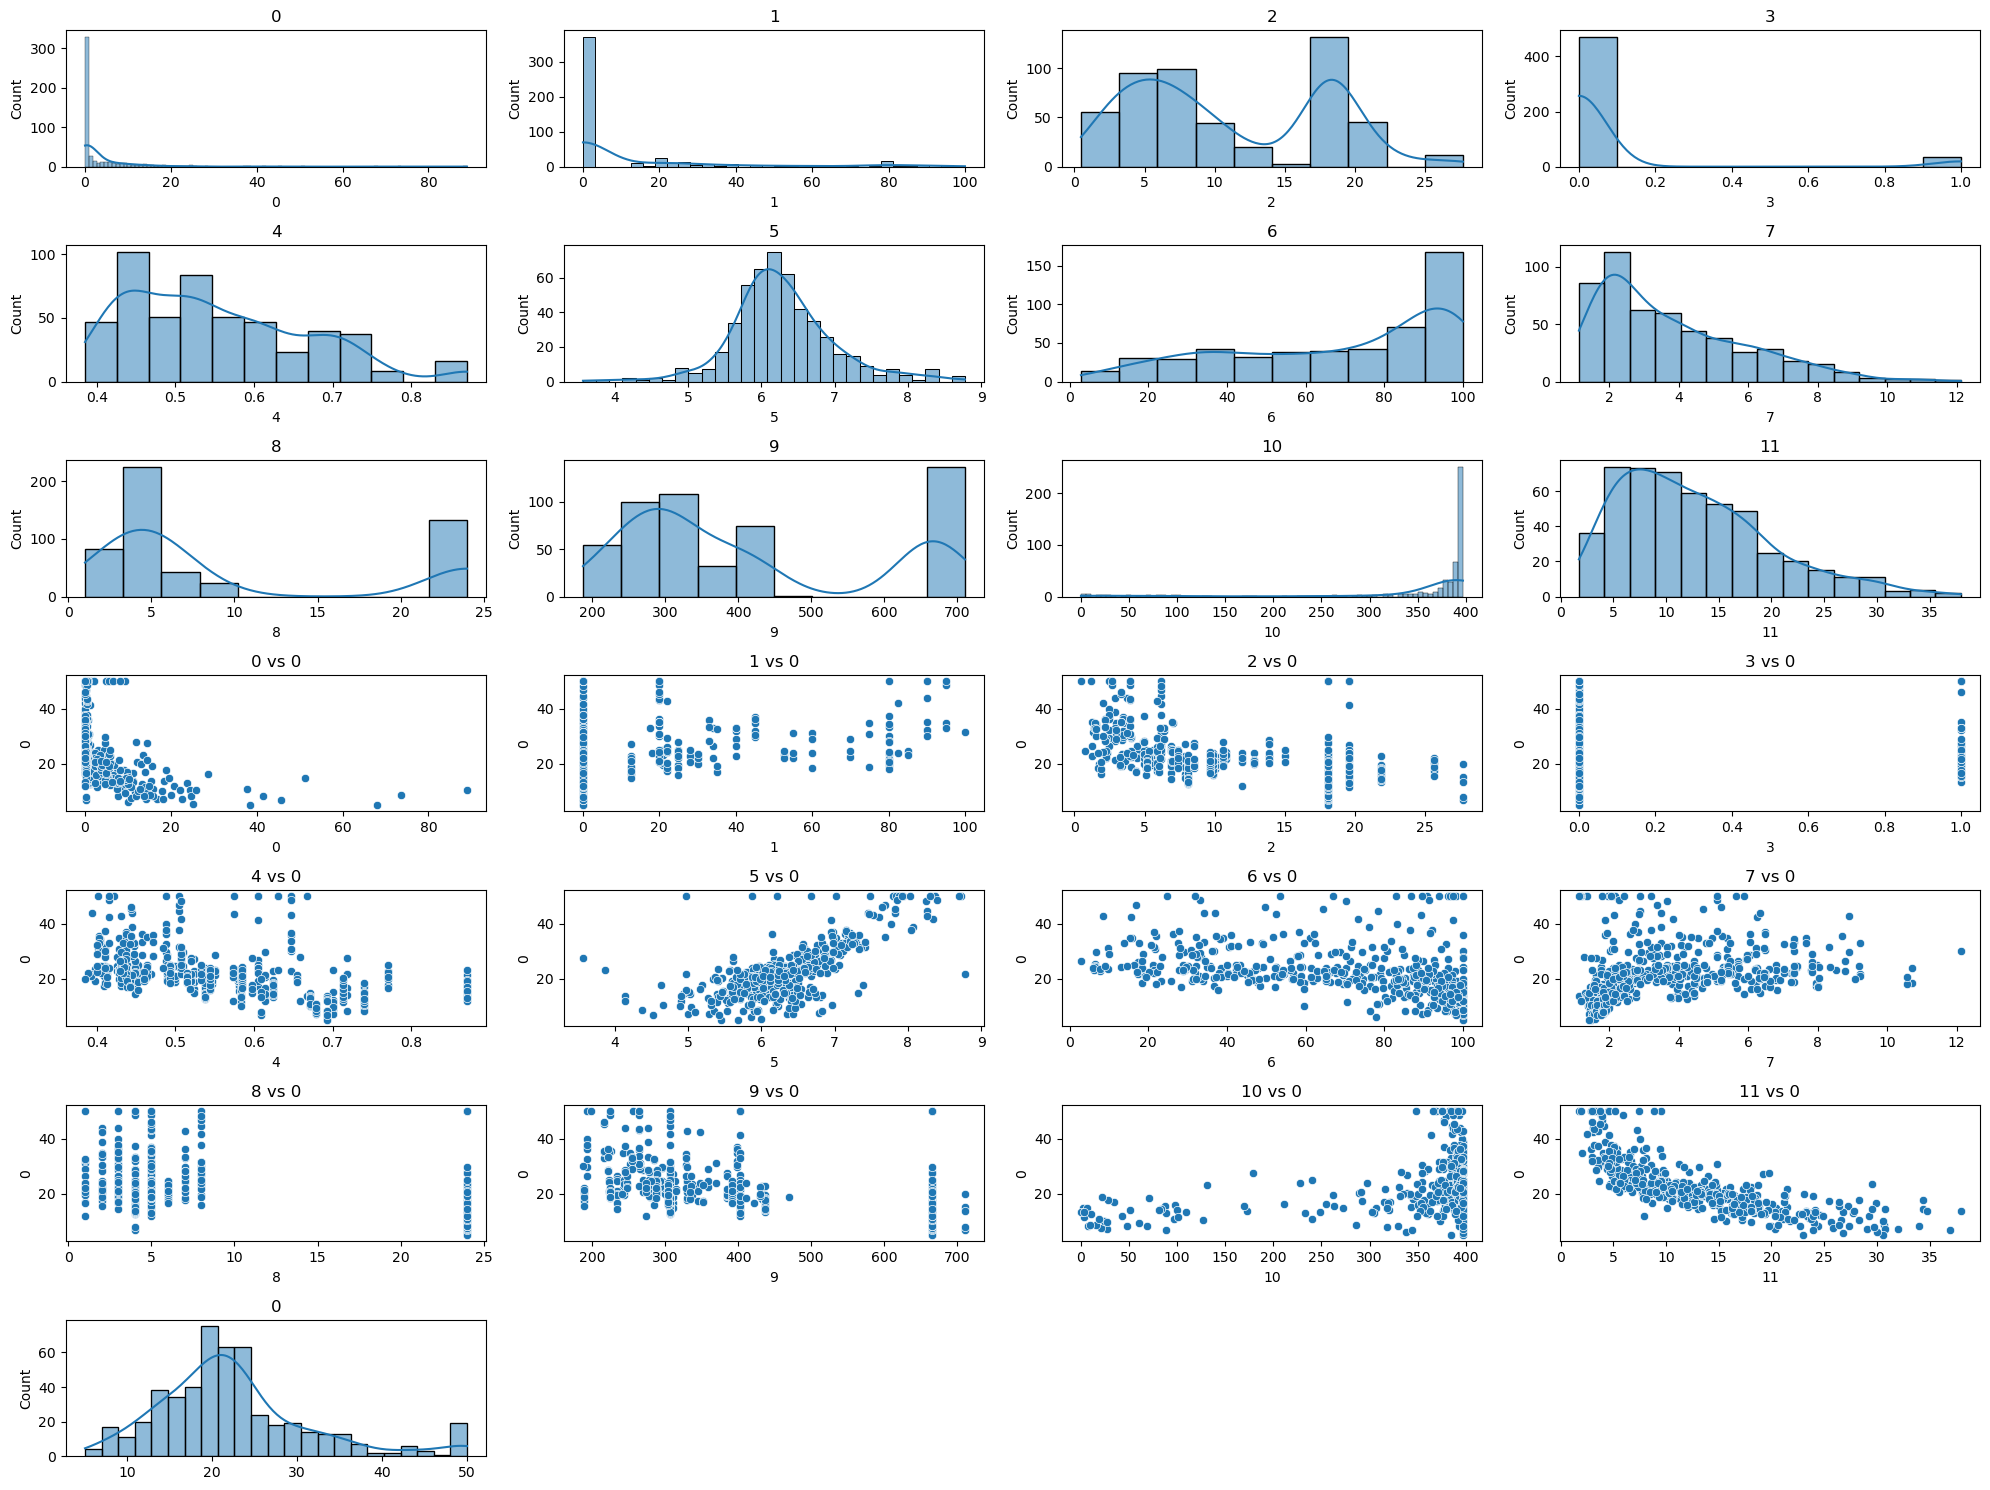

In [ ]:
# Plot data
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(X, y, cols=4):
    fig, axs = plt.subplots(
        (X.shape[1]+X.shape[1]*y.shape[1] + y.shape[1]+cols-1)//cols, cols, figsize=(20, 15))
    axs = axs.flatten()

    a = 0
    for i, col in enumerate(X.columns):
        data = X[col].to_numpy()
        ax = axs[a+i]
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(col)
        ax.set_xlabel(col)
        ax.tick_params(axis='both', which='major')
        ax.tick_params(axis='both', which='minor')
    a += i + 1
    for i, col in enumerate(X.columns):
        data = X[col].to_numpy()
        for j, ycol in enumerate(y.columns):
            ax = axs[a+i+j*y.shape[1]]
            sns.scatterplot(x=data, y=y[ycol], ax=ax)
            ax.set_title(f'{col} vs {ycol}')
            ax.set_xlabel(col)
            ax.set_ylabel(ycol)
    a += i + 1
    for i, col in enumerate(y.columns):
        data = y[col].to_numpy()
        ax = axs[a+i]
        sns.histplot(data, kde=True, ax=ax)
        ax.set_title(col)
    a += i+1
    for j in range(a, len(axs)):
        fig.delaxes(axs[j])

    fig.tight_layout()
    plt.show()
    
plot_data(X, y)

In [ ]:
# Define search
from optuna.integration.sklearn import OptunaSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer

SCALERS = {
    'identity': FunctionTransformer(func=None, inverse_func=None),
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'quantile': QuantileTransformer(),
}

search_params = {
    'cv': 5,
    'n_jobs': -1,  # -1,
    'n_trials': 1,
    # 'n_trials': None,
    'random_state': 42,
    'return_train_score': True,
    'scoring': 'r2',
    'timeout': 10,
    # 'timeout': None,
    'verbose': 1
}

# default_search = SCALERS['robust']  # SCALERS['identity']
default_search = SCALERS['identity']


def search(model, param_grid={}, scaler=default_search, search_params=search_params):
    search_params = search_params.copy()
    # search_params['n_trials'] = int(4**len(param_grid))
    return OptunaSearchCV(Pipeline([('scaler', scaler), ('model', model)]), {f'model__{k}': v for k, v in param_grid.items()}, **search_params)

In [ ]:
# Define search grids
from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution

mlp_sk_param_grid = {
    'learning_rate_init': FloatDistribution(1e-2, 1e-1, log=True),
    'max_iter': IntDistribution(400, 400, log=True),
    # 'early_stopping': CategoricalDistribution([True]),
}

fonn1_sk_param_grid = {
    'learning_rate_init': FloatDistribution(1e-2, 1e-1, log=True),
    'max_iter': IntDistribution(400, 400, log=True),
}
 
fonn2_sk_param_grid = {
    'learning_rate_init': FloatDistribution(1e-2, 1e-1, log=True),
    'max_iter': IntDistribution(400, 400, log=True),
}

mlp_old_param_grid = {
    'learning_rate_init': FloatDistribution(1e-4, 1e-2, log=True),
    'max_iter': IntDistribution(1000, 1000, log=True),
    # 'early_stopping': CategoricalDistribution([True]),
}

fonn1_old_param_grid = {
    'learning_rate_init': FloatDistribution(1e-3, 1e-2, log=True),
    'max_iter': IntDistribution(2000, 2000, log=True),
}
 
fonn2_old_param_grid = {
    'learning_rate_init': FloatDistribution(1e-4, 1e-2, log=True),
    'max_iter': IntDistribution(1000, 1000, log=True),
}

In [ ]:
from models_sklearn import Tree, Ensemble, MLP as MLP_sk, FONN1 as FONN1_sk, FONN2 as FONN2_sk, TREENN1 as TREENN1_sk, TREENN2 as TREENN2_sk
from models import MLP, FONN1, FONN2, TREENN1, TREENN2
from models_old import FONN1 as FONN1_old, FONN2 as FONN2_old, TREENN1 as TREENN1_old, TREENN2 as TREENN2_old

models = {}

num_trees_input = 5
num_trees_hidden = 5
# hidden_nodes = [10]
hidden_nodes = [5, 10]

# scalers = ['identity', 'robust']
# scalers = ['robust']
scalers = ['identity']

models['Tree'] = search(Tree())
for hn in hidden_nodes:
    for s in scalers:
        scaler = SCALERS[s]
        models[f'Ensemble_sk_{s} {hn}'] = search(Ensemble(hn))
        models[f'MLP_sk_{s} {hn}'] = search(
            MLP_sk(hn), mlp_sk_param_grid, scaler)
#         models[f'MLP_sk_tanh_{s} {hn}'] = search(
#             MLP_sk(hn, activation='tanh'), mlp_sk_param_grid, scaler)
#         models[f'FONN1_sk_{s} {num_trees_input} {hn}'] = search(
#             FONN1_sk(num_trees_input, num_trees_input+hn), fonn1_sk_param_grid, scaler)
#         models[f'FONN2_sk_{s} {num_trees_hidden} {hn}'] = search(
#             FONN2_sk(hn, num_trees_hidden+hn), fonn2_sk_param_grid, scaler)
# if isinstance(hn, tuple):
#     models[f'Ensemble {sum(hn)}'] = search(Ensemble(sum(hn)))
#     models[f'FONN1_sk {num_trees_input} {hn}'] = search(
#         FONN1_sk(num_trees_input, (num_trees_input+hn[0], *hn[1:])), mlp_sk_param_grid)
#     models[f'FONN2_sk {num_trees_hidden} {hn}'] = search(
#         FONN2_sk(num_trees_hidden, (*hn[:-1], num_trees_hidden+hn[-1])), mlp_sk_param_grid)
#     models[f'TREENN1_sk {hn}'] = search(
#         TREENN1_sk((1+hn[0], *hn[1:])), mlp_sk_param_grid)
#     models[f'TREENN2_sk {hn}'] = search(
#         TREENN2_sk((*hn[:-1], 1+hn[-1])), mlp_sk_param_grid)

input_dim = X.shape[1]
output_dim = 1

for hn in hidden_nodes:
    #     models[f'MLP {hn}'] = search(
    #         MLP(input_dim, hn, output_dim), mlp_param_grid)
    #     models[f'MLP_tanh {hn}'] = search(
    #         MLP(input_dim, hn, output_dim, activation='tanh'), mlp_param_grid)
    #     models[f'FONN1 {num_trees_input} {hn}'] = search(
    #         FONN1(input_dim, hn, output_dim, num_trees_input), mlp_param_grid)
    #     models[f'FONN2 {num_trees_hidden} {hn}'] = search(
    #         FONN2(input_dim, hn, output_dim, num_trees_hidden), mlp_param_grid)
    #     models[f'TREENN1 {hn}'] = search(
    #         FONN1(input_dim, hn, output_dim, 1), mlp_param_grid)
    #     models[f'TREENN2 {hn}'] = search(
    #         FONN2(input_dim, hn, output_dim, 1), mlp_param_grid)
    models[f'MLP_old {hn}'] = search(
        MLP(input_dim, hn, output_dim), mlp_old_param_grid)
    models[f'FONN1_old {num_trees_input} {hn}'] = search(
        FONN1(input_dim, hn, output_dim, num_trees_input), fonn1_old_param_grid)
    models[f'FONN2_old {num_trees_hidden} {hn}'] = search(
        FONN2(input_dim, hn, output_dim, num_trees_hidden), fonn2_old_param_grid)
    models[f'TREENN1_old {hn}'] = search(
        FONN1(input_dim, hn, output_dim, 1), fonn1_old_param_grid)
    models[f'TREENN2_old {hn}'] = search(
        FONN2(input_dim, hn, output_dim, 1), fonn2_old_param_grid)

display(models)

{'Tree': OptunaSearchCV(cv=5,
                estimator=Pipeline(steps=[('scaler', FunctionTransformer()),
                                          ('model', Tree())]),
                n_jobs=-1, n_trials=1, param_distributions={}, random_state=42,
                return_train_score=True, scoring='r2', timeout=10, verbose=1),
 'Ensemble_sk_identity 5': OptunaSearchCV(cv=5,
                estimator=Pipeline(steps=[('scaler', FunctionTransformer()),
                                          ('model', Ensemble(n_estimators=5))]),
                n_jobs=-1, n_trials=1, param_distributions={}, random_state=42,
                return_train_score=True, scoring='r2', timeout=10, verbose=1),
 'MLP_sk_identity 5': OptunaSearchCV(cv=5,
                estimator=Pipeline(steps=[('scaler', FunctionTransformer()),
                                          ('model', MLP(hidden_layer_sizes=5))]),
                n_jobs=-1, n_trials=16,
                param_distributions={'model__learning_rate_init'

In [ ]:
# Train and evaluate models
cv_results = {}
results = []

result_columns = [
    'mean_fit_time', 'mean_score_time', 'mean_train_score', 'mean_test_score'
]


def fit_model(name, model, X, y):
    print(f"Fitting {name}...")
    model.fit(X, y.to_numpy().ravel())
    result = model.cv_results_
    cv_results[name] = result
    return {
        'model': name,
        **{col: result[col][model.best_index_] for col in result}
    }


for name, model in models.items():
    results.append(fit_model(name, model, X, y))

results_df = pd.DataFrame(results)
results_df.set_index('model', inplace=True)
results_df = results_df[result_columns]

[I 2024-11-30 02:10:53,484] A new study created in memory with name: no-name-e16ac3f5-551c-4a94-acf9-f78790486a62
[I 2024-11-30 02:10:53,516] Trial 0 finished with value: 0.32468074231076643 and parameters: {}. Best is trial 0 with value: 0.32468074231076643.
[I 2024-11-30 02:10:53,522] A new study created in memory with name: no-name-4d53f992-f948-4bcb-ae12-7a2588ac852b
[I 2024-11-30 02:10:53,595] Trial 0 finished with value: 0.48826039896350704 and parameters: {}. Best is trial 0 with value: 0.48826039896350704.
[I 2024-11-30 02:10:53,612] A new study created in memory with name: no-name-3ec150fd-b738-4b4b-8d22-2bdcecc73e92


Fitting Tree...
Fitting Ensemble_sk_identity 5...
Fitting MLP_sk_identity 5...


In [ ]:
display(results_df,
        results_df.sort_values(by='mean_test_score', ascending=False),
        results_df.sort_values(by='mean_train_score', ascending=False))

,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
model,,,,
Tree,0.003312,0.000926,0.902983,0.172188
Ensemble_sk_standard 5,0.010875,0.001141,0.960605,0.487523
MLP_sk_standard 5,0.049990,0.000978,0.822837,0.449183
MLP_sk_tanh_standard 5,0.081517,0.001058,0.730762,-0.392976
FONN1_sk_standard 5 5,0.058089,0.001622,0.965839,0.506110
FONN2_sk_standard 5 5,0.316413,0.000973,0.818100,0.473740
Ensemble_sk_standard 10,0.020495,0.001222,0.972221,0.513557
MLP_sk_standard 10,0.026251,0.000928,0.842259,0.107983
MLP_sk_tanh_standard 10,0.107020,0.000931,0.835047,-0.414430


,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
model,,,,
FONN1_sk_standard 5 10,0.032562,0.001257,0.949051,0.548288
Ensemble_sk_standard 10,0.020495,0.001222,0.972221,0.513557
FONN1_sk_standard 5 5,0.058089,0.001622,0.965839,0.506110
Ensemble_sk_standard 5,0.010875,0.001141,0.960605,0.487523
FONN2_sk_standard 5 5,0.316413,0.000973,0.818100,0.473740
MLP_sk_standard 5,0.049990,0.000978,0.822837,0.449183
Tree,0.003312,0.000926,0.902983,0.172188
MLP_sk_standard 10,0.026251,0.000928,0.842259,0.107983
FONN2_sk_standard 5 10,0.938078,0.000867,0.769452,-0.339667


,mean_fit_time,mean_score_time,mean_train_score,mean_test_score
model,,,,
Ensemble_sk_standard 10,0.020495,0.001222,0.972221,0.513557
FONN1_sk_standard 5 5,0.058089,0.001622,0.965839,0.506110
Ensemble_sk_standard 5,0.010875,0.001141,0.960605,0.487523
FONN1_sk_standard 5 10,0.032562,0.001257,0.949051,0.548288
Tree,0.003312,0.000926,0.902983,0.172188
MLP_sk_standard 10,0.026251,0.000928,0.842259,0.107983
MLP_sk_tanh_standard 10,0.107020,0.000931,0.835047,-0.414430
MLP_sk_standard 5,0.049990,0.000978,0.822837,0.449183
FONN2_sk_standard 5 5,0.316413,0.000973,0.818100,0.473740


In [ ]:
pd.DataFrame({name: model.best_params_ for name,
             model in models.items()}).transpose()

,model__learning_rate_init,model__max_iter
Tree,NaN,NaN
Ensemble_sk_standard 5,NaN,NaN
MLP_sk_standard 5,0.022568,400.0
MLP_sk_tanh_standard 5,0.022682,400.0
FONN1_sk_standard 5 5,0.012550,400.0
FONN2_sk_standard 5 5,0.010099,400.0
Ensemble_sk_standard 10,NaN,NaN
MLP_sk_standard 10,0.050519,400.0
MLP_sk_tanh_standard 10,0.011115,400.0
FONN1_sk_standard 5 10,0.060900,400.0


In [ ]:
# Predictions
predictions = pd.DataFrame(
    {name: model.best_estimator_.predict(X) for name, model in models.items()})
display(pd.concat([y, predictions], axis=1),
        pd.concat([y, predictions], axis=1).describe())

,0,Tree,Ensemble_sk_standard 5,MLP_sk_standard 5,MLP_sk_tanh_standard 5,FONN1_sk_standard 5 5,FONN2_sk_standard 5 5,Ensemble_sk_standard 10,MLP_sk_standard 10,MLP_sk_tanh_standard 10,FONN1_sk_standard 5 10,FONN2_sk_standard 5 10
0,24.0,23.9,24.52,25.246102,23.871729,25.920197,25.111463,25.75,27.663957,26.056923,24.678660,26.928053
1,21.6,21.6,20.58,21.738179,20.687324,21.521526,23.575122,20.55,23.477798,23.733910,21.485996,22.989510
2,34.7,33.4,33.88,31.872767,31.939549,36.645048,32.524753,34.08,34.279180,32.633922,34.004305,33.661803
3,33.4,33.4,33.60,30.741877,30.929729,34.381067,31.395589,34.17,33.259701,31.067118,33.756120,32.206352
4,36.2,36.2,36.20,31.197291,29.773932,36.322490,31.738995,35.77,33.241824,32.297976,34.387026,31.785826
...,...,...,...,...,...,...,...,...,...,...,...,...
501,22.4,22.4,27.62,26.051795,23.164607,23.893870,26.045663,23.14,24.595866,24.183896,23.468845,26.660476
502,20.6,11.9,21.14,21.901852,19.294124,21.757593,22.095347,20.71,21.990428,22.920924,21.717814,24.504078
503,23.9,23.6,24.80,31.771423,28.203541,27.018011,31.903391,26.70,31.816258,25.715260,24.348753,34.028192
504,22.0,22.0,26.10,28.766099,24.954327,21.830605,28.814329,24.39,27.212598,24.630245,23.389686,30.692910


,0,Tree,Ensemble_sk_standard 5,MLP_sk_standard 5,MLP_sk_tanh_standard 5,FONN1_sk_standard 5 5,FONN2_sk_standard 5 5,Ensemble_sk_standard 10,MLP_sk_standard 10,MLP_sk_tanh_standard 10,FONN1_sk_standard 5 10,FONN2_sk_standard 5 10
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,22.532806,22.506324,22.423202,22.611979,22.066370,22.577046,22.460953,22.531976,22.647392,22.287507,22.556619,22.674124
std,9.197104,9.070651,8.668694,8.574739,8.220763,9.094234,8.807159,8.811564,9.296856,8.155209,9.008535,8.912495
min,5.000000,5.000000,6.040000,2.857410,0.307646,4.363029,3.180213,5.890000,5.456069,0.875583,5.010034,6.134643
25%,17.025000,17.525000,16.900000,16.786993,16.527417,16.904773,16.902063,17.200000,16.726575,16.710878,17.125388,16.506885
50%,21.200000,21.050000,21.180000,21.551785,21.410596,21.226041,21.099414,21.035000,21.282382,21.488901,21.258186,21.350905
75%,25.000000,25.975000,25.475000,26.904919,25.689439,25.916493,26.148366,25.772500,26.202035,26.545619,25.551677,26.653653
max,50.000000,50.000000,50.000000,50.220591,44.181179,51.471112,54.707373,50.000000,53.279795,45.387900,50.615084,52.151914


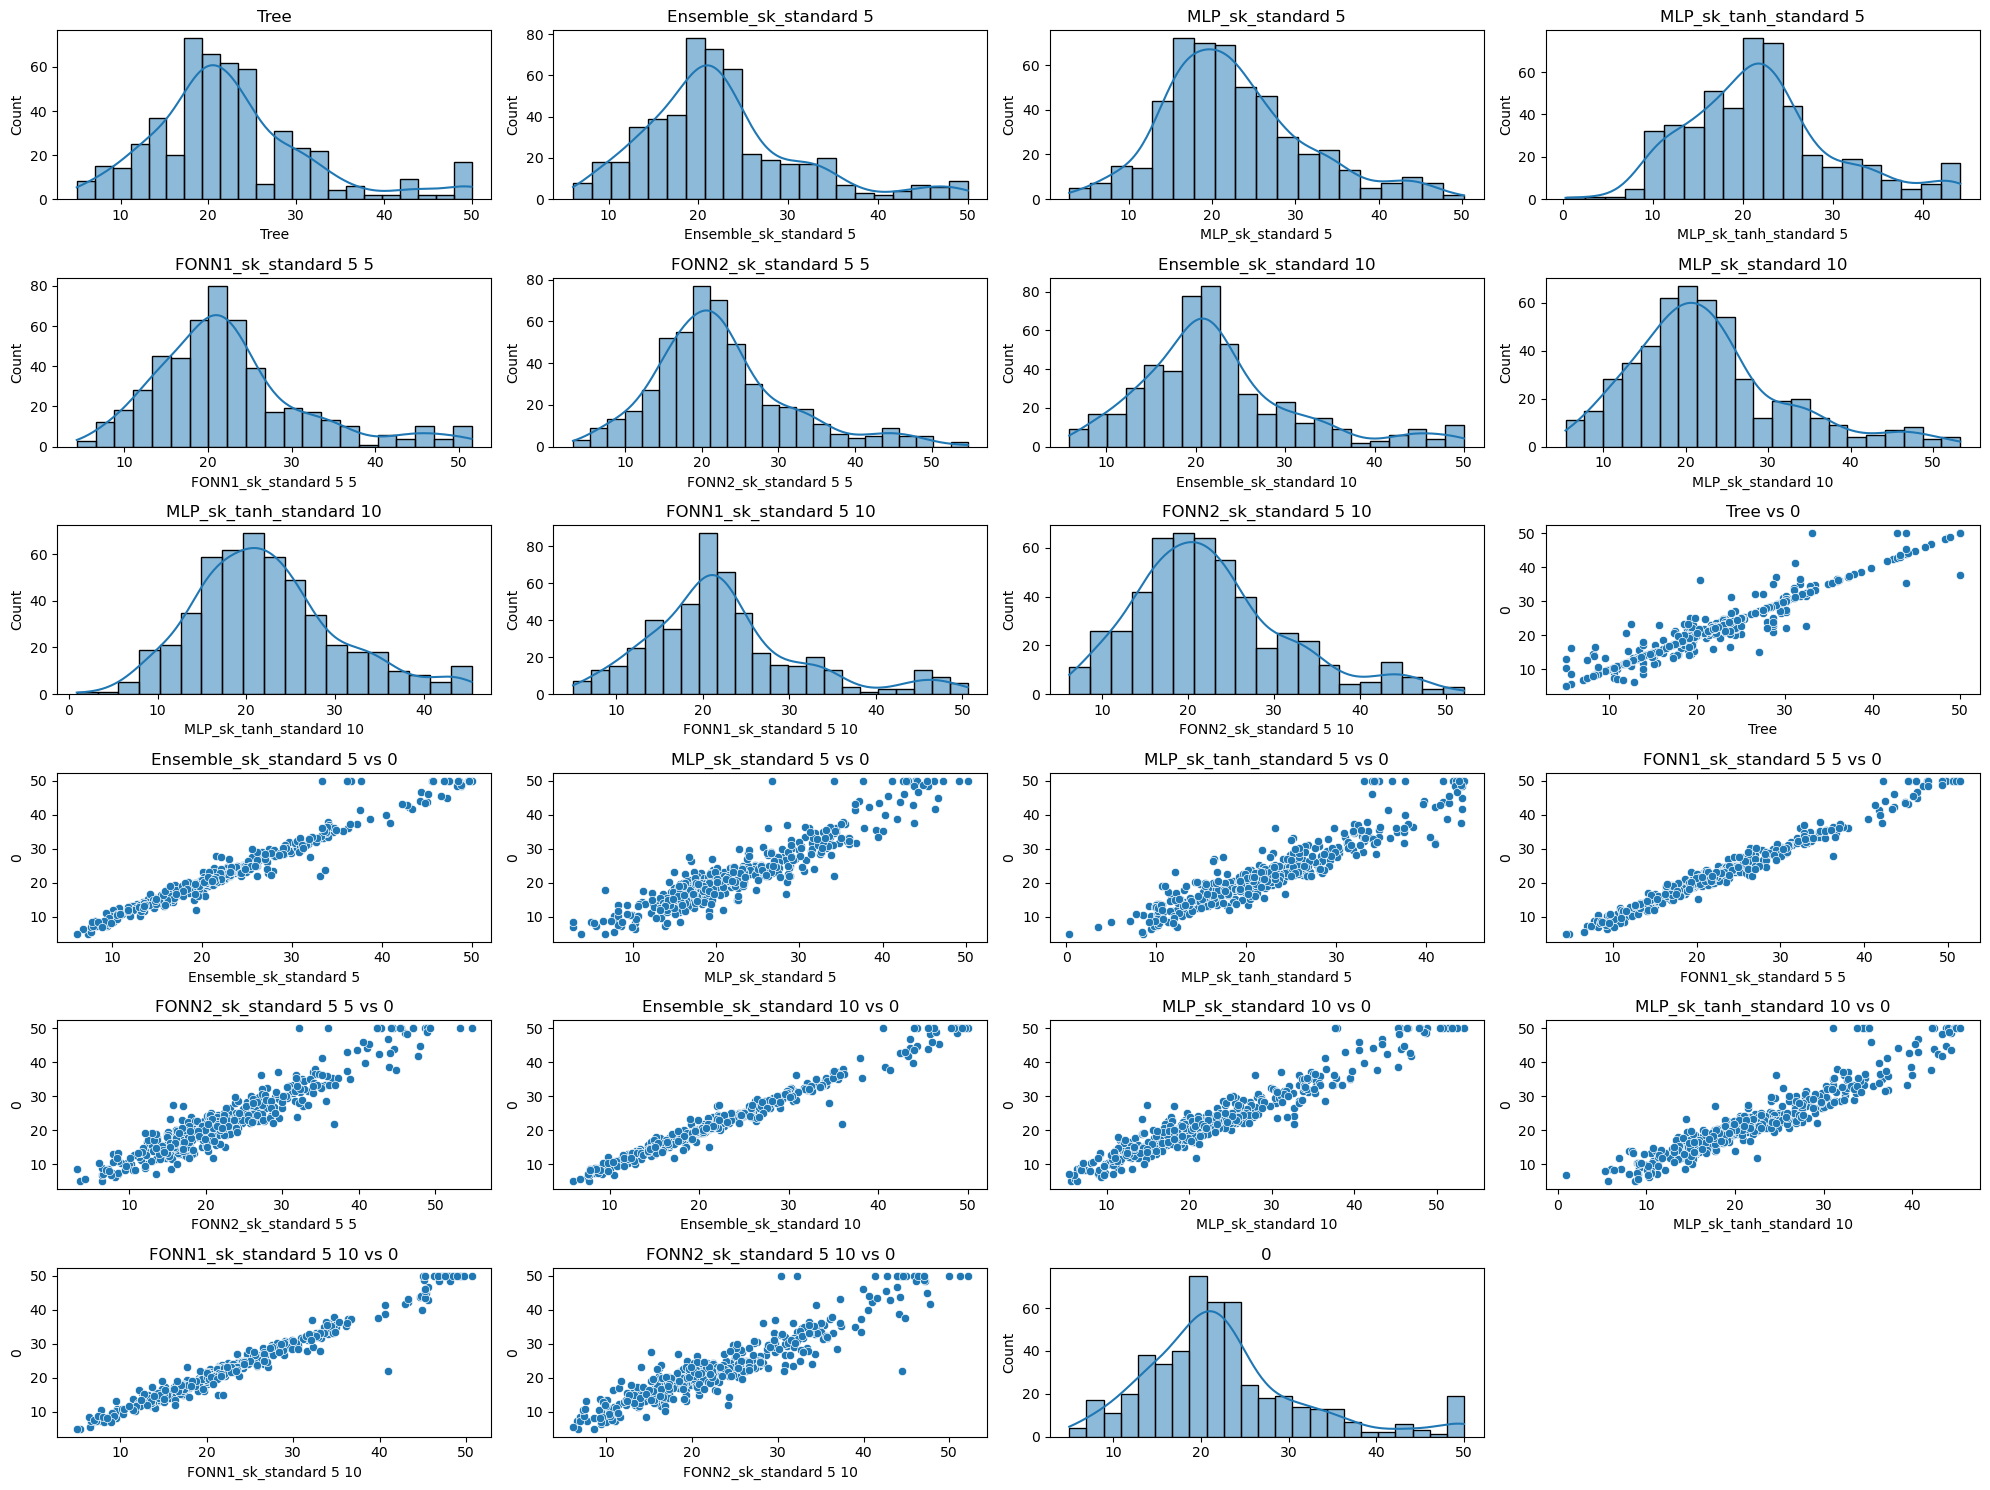

In [ ]:
# Plot Predictions
plot_data(predictions, y)

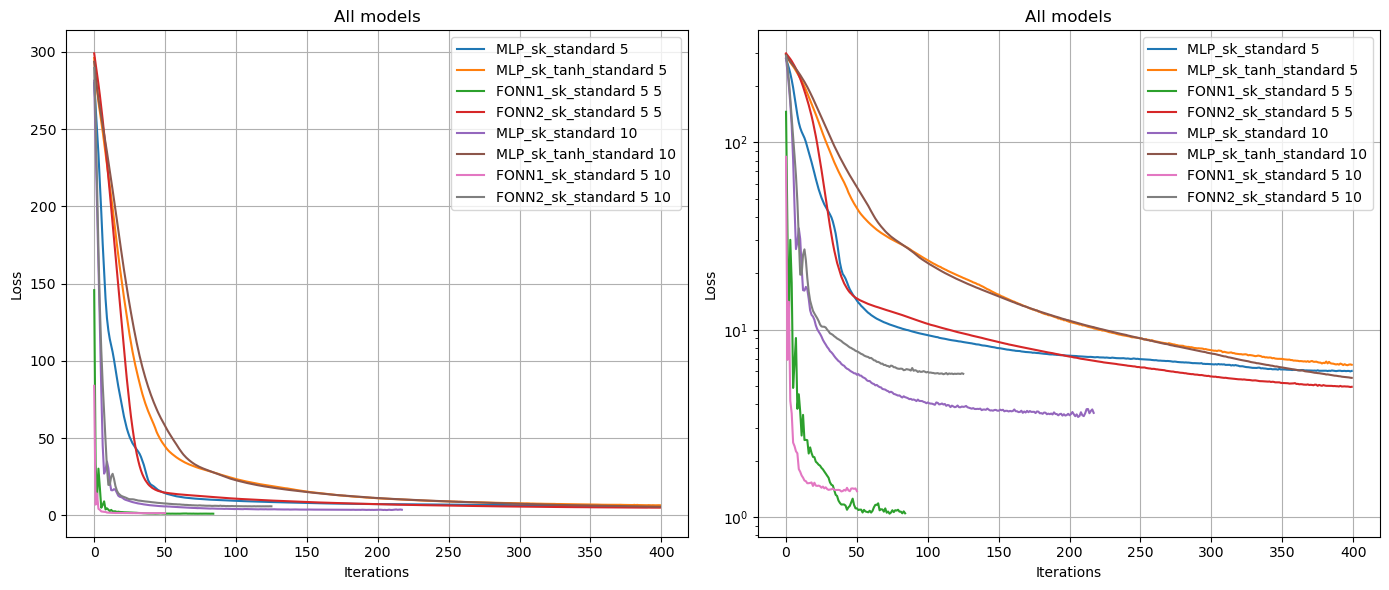

In [ ]:
import matplotlib.pyplot as plt


def plot_loss(model, ax1, ax2, label):
    ax1.plot(model.loss_curve_, label=label)
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.plot(model.loss_curve_, label=label)
    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.grid(True)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for model_name, model in models.items():
    if hasattr(model.best_estimator_['model'], 'loss_curve_'):
        plot_loss(model.best_estimator_['model'], ax1, ax2, label=model_name)

ax1.set_xlabel('Iterations')
ax1.set_ylabel('Loss')
ax1.set_title('All models')
ax1.legend()
ax1.grid(True)

ax2.set_yscale('log')
ax2.set_xlabel('Iterations')
ax2.set_ylabel('Loss')
ax2.set_title('All models')
ax2.legend()
ax2.grid(True)

fig.tight_layout()
fig.show()

In [ ]:
import matplotlib.pyplot as plt

plot_groups = {}
for model_name, model in models.items():
    if hasattr(model.best_estimator_['model'], 'loss_curve_'):
        key = model_name.split('_' if '_' in model_name else ' ')[0]
        if key not in plot_groups:
            plot_groups[key] = plt.subplots(1, 2, figsize=(14, 6))
        fig, (ax1, ax2) = plot_groups[key]
        plot_loss(model.best_estimator_['model'], ax1, ax2, model_name)

for group, plot in plot_groups.items():
    fig, (ax1, ax2) = plot
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')
    ax1.set_title(group)
    ax1.legend()
    ax1.grid(True)

    ax2.set_yscale('log')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Loss')
    ax2.set_title(group)
    ax2.legend()
    ax2.grid(True)

    fig.tight_layout()
    fig.show()

Error in callback <function flush_figures at 0x7f3e7f620cc0> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
for model_name, model in models.items():
    if hasattr(model.best_estimator_['model'], 'loss_curve_'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        plot_loss(model.best_estimator_['model'], ax1, ax2, model_name)
        ax1.set_title(model_name)
        ax2.set_title(model_name)
        fig.tight_layout()
        fig.show()